In [260]:
from osgeo import gdal
from PIL import Image
from osgeo import gdal_array
import pylab as plt
import matplotlib.image as mpimg
import csv
import numpy as np
import geopandas as gpd
from sklearn.model_selection import KFold 
from sklearn import cross_validation
import matplotlib.patches as mpatches
%matplotlib inline

### Import the NYC satellite image
Note it's a multi-spectral image from the Landsat 8 satellite. This is the most commonly used remote sensing imagery. It has 12 bands as listed in the table below.

In [261]:
dataset = gdal.Open('data/NYC_test.tif', gdal.GA_ReadOnly)

# How many bands does this image have?
num_bands = dataset.RasterCount
print('Number of bands in image: {n}'.format(n=num_bands))

# How many rows and columns?
rows = dataset.RasterYSize
cols = dataset.RasterXSize
print('Image size is: {r} rows x {c} columns'.format(r=rows, c=cols))

Number of bands in image: 12
Image size is: 519 rows x 623 columns


### Here are the bands in our image:

In [262]:
with open('data/table.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        print ('     '.join(row))

﻿Name     Description
B1     "Band 1 (Ultra Blue) surface reflectance      0.435-0.451 μm"
B2     "Band 2 (Blue) surface reflectance      0.452-0.512 μm"
B3     "Band 3 (Green) surface reflectance      0.533-0.590 μm"
B4     "Band 4 (Red) surface reflectance      0.636-0.673 μm"
B5     "Band 5 (Near Infrared) surface reflectance      0.851-0.879 μm"
B6     "Band 6 (Shortwave Infrared 1) surface reflectance      1.566-1.651 μm"
B7     "Band 7 (Shortwave Infrared 2) surface reflectance      2.107-2.294 μm"
B10     "Band 10 brightness temperature (Kelvin)      10.60-11.19 μm"
B11     "Band 11 brightness temperature (Kelvin)      11.50-12.51 μm"
sr_aerosol     "Aerosol attributes      see Aerosol QA table"
pixel_qa     "Pixel quality attributes      see Pixel QA table"
radsat_qa     "Radiometric saturation QA      see Radsat QA table"


#### Make a dictionary of them

In [263]:
band_dict = {'B1':'Ultra blue','B2':'Blue','B3':'Green','B4':'Red','B5':'NIR','B6':'Shortwave IR 1','B7':'Shortwave IR 2','B10':'Thermal 1','B11':'Thermal 2'}
band_dict

{'B1': 'Ultra blue',
 'B10': 'Thermal 1',
 'B11': 'Thermal 2',
 'B2': 'Blue',
 'B3': 'Green',
 'B4': 'Red',
 'B5': 'NIR',
 'B6': 'Shortwave IR 1',
 'B7': 'Shortwave IR 2'}

### Show which Numpy index values go with the official band names

In [264]:
for i in range(7):
    my_key="B"+str(i+1)
    print(i, band_dict[my_key])
    
    # This needs an exception clause
    # Fix it so it shows all the bands with range(num_bands)

0 Ultra blue
1 Blue
2 Green
3 Red
4 NIR
5 Shortwave IR 1
6 Shortwave IR 2


In [265]:
# What driver was used to open the raster?
driver = dataset.GetDriver()
print('Raster driver: {d}\n'.format(d=driver.ShortName))

Raster driver: GTiff



### Load the pixel values into a Numpy array

In [266]:
# Initialize a 3d array -- size based on raster dimensions
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount))

# Allocate array using the first band's datatype
image_datatype = dataset.GetRasterBand(1).DataType

image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset

for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()


In [267]:
## Ignore this part

import numpy, sys
from osgeo import gdal
from osgeo.gdalconst import *


# register all of the GDAL drivers
gdal.AllRegister()

# open the image
inDs = gdal.Open("data/NYC_test.tif")
if inDs is None:
  print('Could not open image file')
  sys.exit(1)

# read in the crop data and get info about it
band1 = inDs.GetRasterBand(1)
rows = inDs.RasterYSize
cols = inDs.RasterXSize

cropData = band1.ReadAsArray(0,0,cols,rows)

listAg = [1,5,6,22,23,24,41,42,28,37]
listNotAg = [111,195,141,181,121,122,190,62]

# create the output image
driver = inDs.GetDriver()
#print driver
outDs = driver.Create("data/NYC_OP.tif", cols, rows, 1, GDT_Int32)
if outDs is None:
    print ('Could not create reclass_40.tif')
    sys.exit(1)

outBand = outDs.GetRasterBand(1)
outData = numpy.zeros((rows,cols), numpy.int16)


for i in range(0, rows):
    for j in range(0, cols):

        if cropData[i,j] in listAg:
            outData[i,j] = 100
        elif cropData[i,j] in listNotAg:
            outData[i,j] = -100
        else:
            outData[i,j] = 0


# write the data
outBand.WriteArray(outData, 0, 0)

# flush data to disk, set the NoData value and calculate stats
outBand.FlushCache()
outBand.SetNoDataValue(-99)

# georeference the image and set the projection
outDs.SetGeoTransform(inDs.GetGeoTransform())
outDs.SetProjection(inDs.GetProjection())

del outData

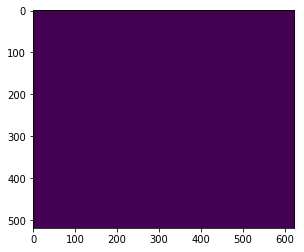

In [268]:
## This too

from PIL import Image
dataset = gdal.Open('data/NYC_OP.tif', gdal.GA_ReadOnly)
plt.imshow(dataset.GetRasterBand(1).ReadAsArray())

In [269]:
dataset.GetRasterBand(1)

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7faedcedc870> >

### Inspect the bands

In [270]:
for i in range(dataset.RasterCount):
    print("Band {} has mean value {}".format(i,np.nanmean(image[:,:,i])))

print

for i in range(dataset.RasterCount):
    print("Band {} has st dev {}".format(i,np.nanstd(image[:,:,i])))


Band 0 has mean value 0.0798923522233963
Band 0 has st dev 0.04225686565041542


### Create NDVI band out of the red and NIR

In [271]:
b_red = 3
b_nir = 4

ndvi = (image[:, :, b_nir] - image[:, :, b_red]) / (image[:, :, b_red] + image[:, :, b_nir])

print(ndvi)

[[ 0.21166135  0.21166135  0.42605364 ...  0.75779814  0.7599498
   0.74625933]
 [ 0.5619275   0.5619275   0.58352405 ...  0.7659447   0.76380366
   0.7526617 ]
 [ 0.53753984  0.53753984  0.599688   ...  0.76157916  0.75359803
   0.72305566]
 ...
 [-0.43237248 -0.40796018 -0.44949493 ...  0.22370231  0.09607055
   0.09607055]
 [-0.42316782 -0.45853657 -0.5        ...  0.14798062  0.16966793
   0.16966793]
 [-0.42718446 -0.45958427 -0.4847775  ...  0.19911137  0.26304382
   0.26304382]]


### Example plot: scatter of red vs infrared values for 30m pixels of the city

Text(0.5,1,'Red versus near infrared')

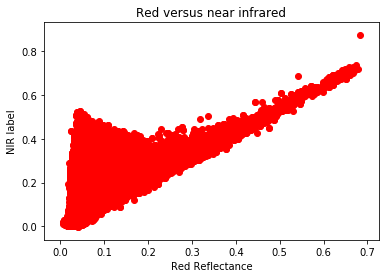

In [272]:
red = np.ndarray.flatten(image[:, :, 3])
nir = np.ndarray.flatten(image[:, :, 4])

# Make the plot
plt.scatter(red, nir, color='r', marker='o')

# Add some axis labels
plt.xlabel('Red Reflectance')
plt.ylabel('NIR label')

# Add a title
plt.title('Red versus near infrared')

### Visualize the individual bands
Write a loop to plot them all

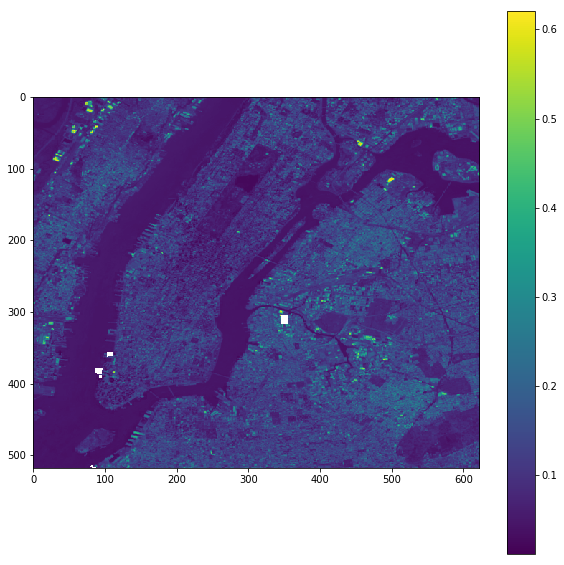

In [273]:
ax = plt.figure(figsize=(10,10))
plt.imshow(image[:,:,2])
plt.colorbar()

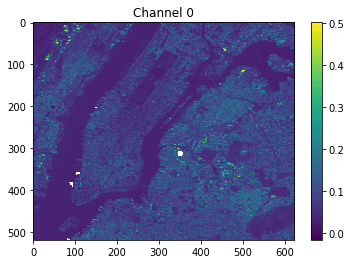

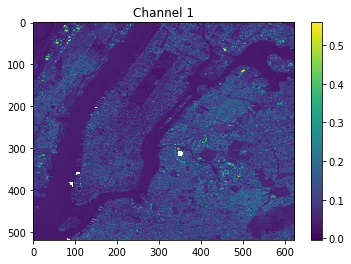

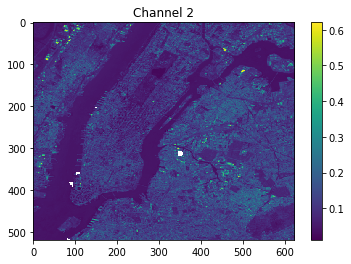

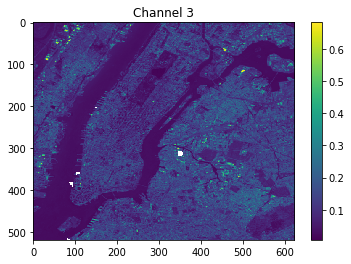

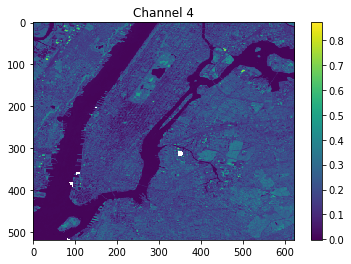

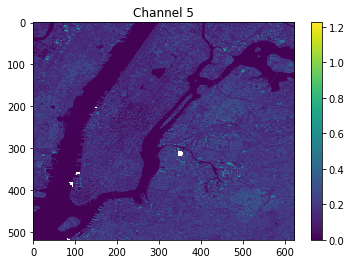

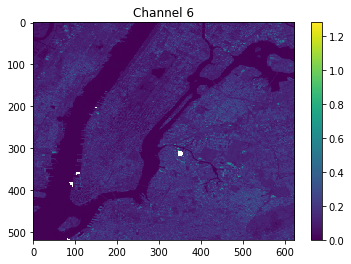

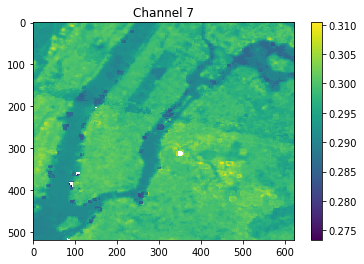

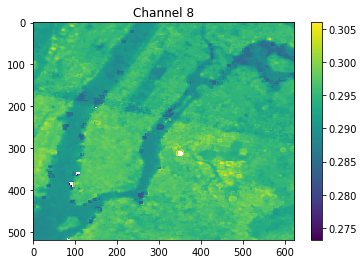

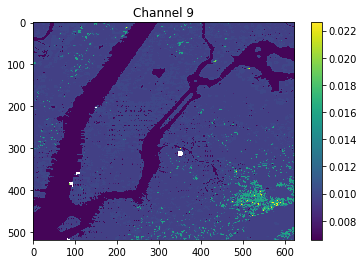

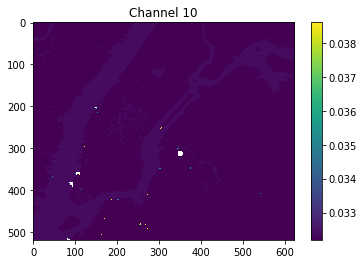

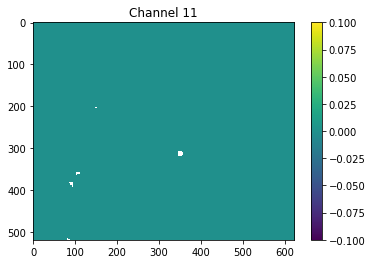

In [274]:
for i in range(num_bands):

    plt.figure()
    plt.title("Channel "+str(i)) # fix dict code then add proper band names
    plt.imshow(image[:,:,i])
    plt.colorbar()
    plt.show()

### Visualize the NDVI
See the high-vegetation parts of the city stand out

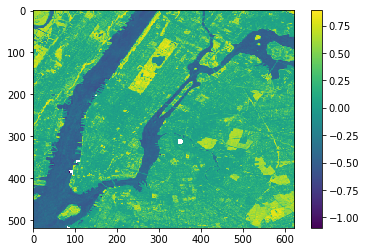

In [275]:
plt.imshow(ndvi)
plt.colorbar()

### Histogram of the bands

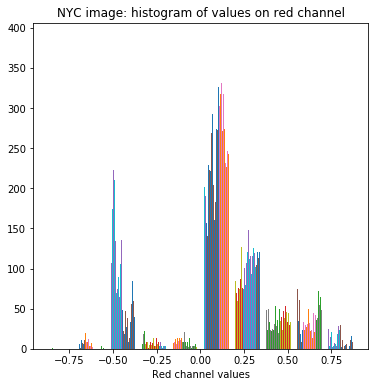

In [276]:
plt.figure(figsize = [6,6])
plt.hist(ndvi)
plt.xlabel("Red channel values")
plt.title("NYC image: histogram of values on red channel");

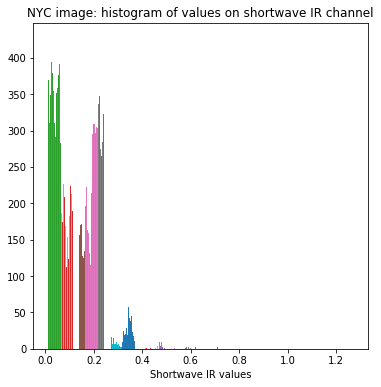

In [277]:
plt.figure(figsize = [6,6])
plt.hist(image[:,:,6])
plt.xlabel("Shortwave IR values")
plt.title("NYC image: histogram of values on shortwave IR channel");

## Histogram for each channel shows their individual 'signatures'
Also shows which part of the spectrum to zoom in on if you want to see most detail.

/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


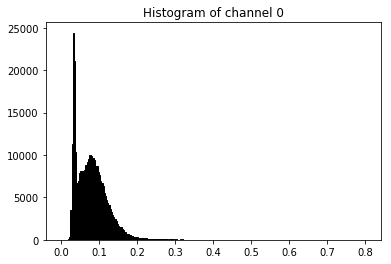

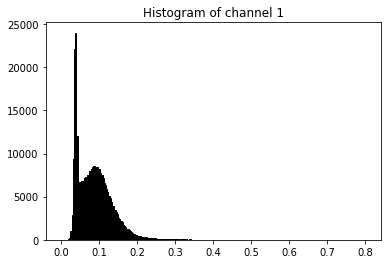

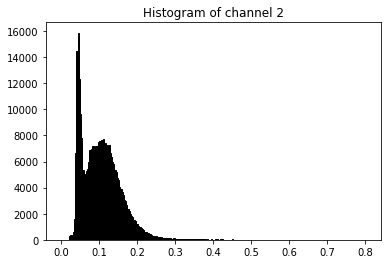

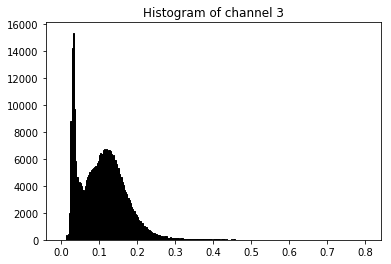

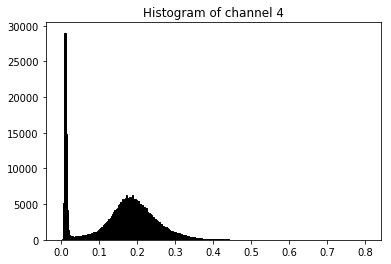

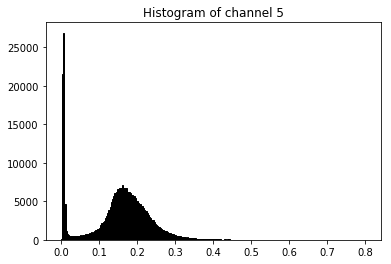

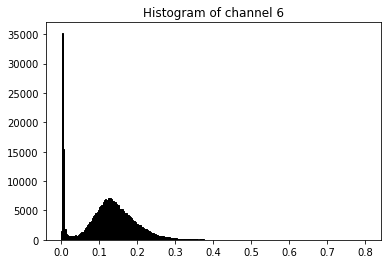

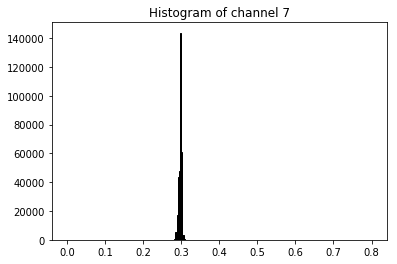

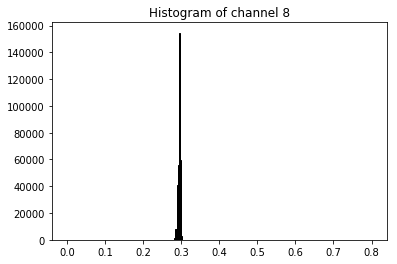

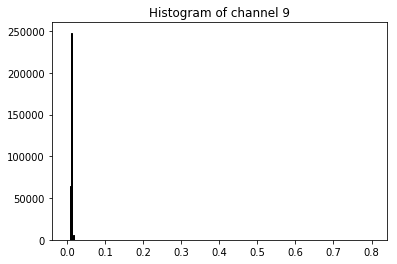

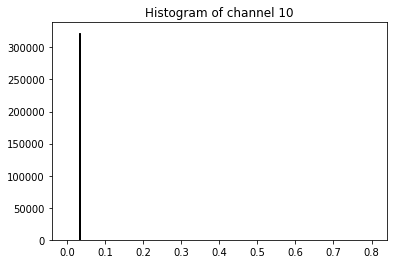

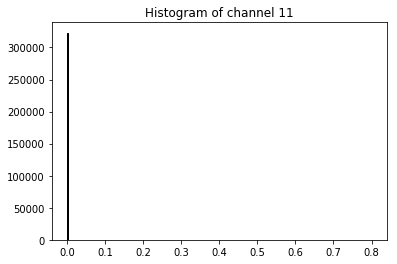

In [278]:
 for i in range(num_bands):
        plt.figure()
        plt.hist(image[:,:,i].ravel(),  range=(0.0, 0.8), bins=256, fc='k', ec='k');
        plt.title('Histogram of channel {}'.format(i))
        plt.show()

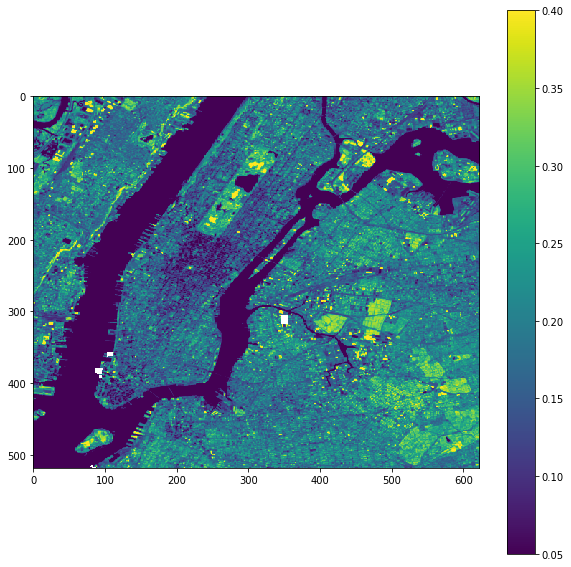

In [279]:
# Using the histogram info above channel 4 above, plot channel 4 (near infrared)
# in the range 0.05 - 0.04. Much more detail highlighted.
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,4],clim=(0.05,0.4))
plt.colorbar()

### Reading NYC shapefile

In [280]:
# Import Python 3 print function
from __future__ import print_function

# Import OGR - 
from osgeo import ogr

# Open the dataset from the file
dataset = ogr.Open('data/NYC_zoning_shape/nyc_zoning_cat.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not dataset:
    print('Error: could not open dataset')

In [281]:
### Let's get the driver from this file
driver = dataset.GetDriver()
print('Dataset driver is: {n}\n'.format(n=driver.name))

### How many layers are contained in this Shapefile?
layer_count = dataset.GetLayerCount()
print('The shapefile has {n} layer(s)\n'.format(n=layer_count))

### What is the name of the 1 layer?
layer = dataset.GetLayerByIndex(0)
print('The layer is named: {n}\n'.format(n=layer.GetName()))

### What is the layer's geometry? is it a point? a polyline? a polygon?
# First read in the geometry - but this is the enumerated type's value
geometry = layer.GetGeomType()

# So we need to translate it to the name of the enum
geometry_name = ogr.GeometryTypeToName(geometry)
print("The layer's geometry is: {geom}\n".format(geom=geometry_name))

### What is the layer's projection?
# Get the spatial reference
spatial_ref = layer.GetSpatialRef()

# Export this spatial reference to something we can read... like the Proj4
proj4 = spatial_ref.ExportToProj4()
print('Layer projection is: {proj4}\n'.format(proj4=proj4))

### How many features are in the layer?
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# How many fields
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))

Dataset driver is: ESRI Shapefile

The shapefile has 1 layer(s)

The layer is named: nyc_zoning_cat

The layer's geometry is: Polygon

Layer projection is: +proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000.0000000001 +y_0=0 +datum=NAD83 +units=us-ft +no_defs 

Layer has 5247 features

Layer has 4 fields
Their names are: 
	ZONEDIST - String
	Shape_Leng - Real
	Shape_Area - Real
	cat - Integer


### Converting to raster

In [282]:
# Import GDAL
from osgeo import gdal

# First we will open our raster image, to understand how we will want to rasterize our vector
raster_ds = gdal.Open('data/NYC_test.tif', gdal.GA_ReadOnly)

# Fetch number of rows and columns
ncol = raster_ds.RasterXSize
nrow = raster_ds.RasterYSize

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create('data/NYC_training_data.tif', ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [0],  # burn value 0
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=cat']  # put raster values according to the 'id' field values
                             )

# Close dataset
out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

Success


In [424]:
# Import NumPy for some statistics
import numpy as np

roi_ds = gdal.Open('data/NYC_training_data.tif', gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 95169 pixels
Class 1 contains 123418 pixels
Class 2 contains 16335 pixels
Class 3 contains 88415 pixels


### Preparing images data

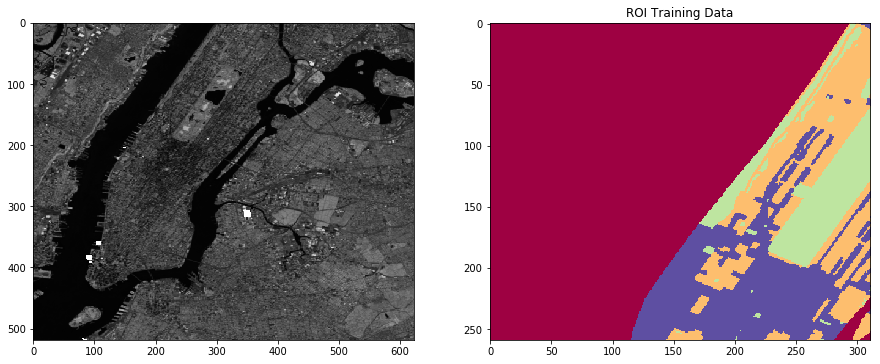

In [465]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('data/NYC_test.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('data/NYC_training_data.tif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# Display them
#plt.subplot(121)
ax.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

#plt.subplot(122)
ax2.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

## Setting up x and y

In [304]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
clear = X[:, 7] <= 1

X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 228168 samples
The training data include 3 classes: [1 2 3]
Our X matrix is sized: (228168, 12)
Our y array is sized: (228168,)
After masking, our X matrix is sized: (227932, 7)
After masking, our y array is sized: (227932,)


## Running RF

In [305]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [443]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 81.79430612459292%


In [307]:
bands = [1, 2, 3, 4, 5, 6,7,8,9,10,11]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.11698419973276536
Band 2 importance: 0.12355802679637494
Band 3 importance: 0.11824754912066292
Band 4 importance: 0.15429608275623216
Band 5 importance: 0.22489302690016236
Band 6 importance: 0.13592930911065204
Band 7 importance: 0.1260918055831502


## Validation

In [308]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict       1      2      3     All
truth                                
1        122562    209    647  123418
2           391  15823    121   16335
3          1005     59  87115   88179
All      123958  16091  87883  227932


In [470]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], 7)

img_as_array = img[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)
# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (519, 623, 12) to (323337, 7)


/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


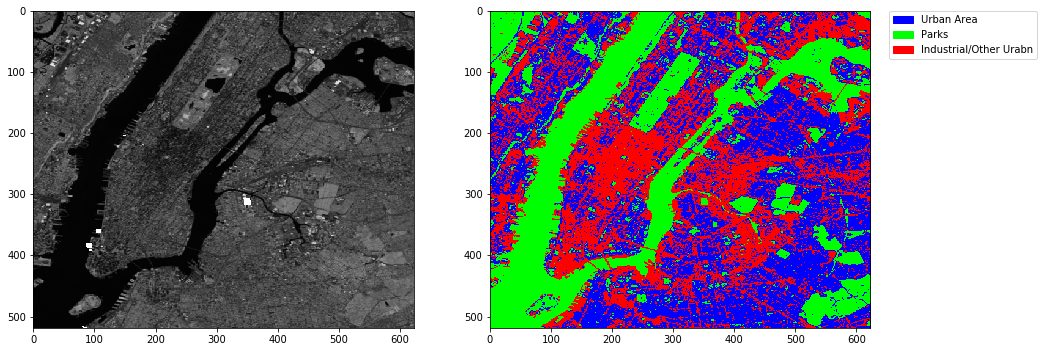

In [471]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # NA  
    (1, (0, 0, 255, 255)),  # Blue ## Urban 
    (2, (0, 255, 0, 255)),  #Green ##Park  
    (3, (255, 0, 0, 255)),  # Red ##Industrial
    (4, (0, 0, 0, 255)),  # NA # 160, 82, 45, 255
    (5, (0, 0, 0, 255))  # NA
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification')

# Now show the classmap next to the image
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121)
ax.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)

ax = f.add_subplot(122)
#plt.subplot(122)
ax.imshow(class_prediction, cmap=cmap, interpolation='none')

######
values = np.unique(class_prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
dic = {0:'Urban Area', 1:'Parks', 2:'Industrial/Other Urabn'}
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=dic[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
######

plt.show()

In [293]:
kf = ms.KFold(n_splits=5)
kf.get_n_splits(img)

5

In [294]:
dic  = dict()
for i in kf.split(image):
    for j in range(1,6):
        dic[j] = i

In [295]:
dic[1][0].shape

(416,)

In [296]:
image.shape

(519, 623, 12)

# To-Do

### Use Phoenix raster and apply it to this model to verify the prediction accuracy

## Phoenix

In [438]:
data_ph = gdal.Open('data/phoenix/phoenix_SM.tif', gdal.GA_ReadOnly)

In [439]:
# Initialize a 3d array -- size based on raster dimensions
image_p = np.zeros((data_ph.RasterYSize, data_ph.RasterXSize, data_ph.RasterCount))

# Allocate array using the first band's datatype
image_p_datatype = data_ph.GetRasterBand(1).DataType

image_p = np.zeros((data_ph.RasterYSize, data_ph.RasterXSize, data_ph.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_p_datatype))

# Loop over all bands in dataset

for b in range(data_ph.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band_p = data_ph.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image_p[:, :, b] = band_p.ReadAsArray()

In [440]:
image_p[0]

array([[0.09965, 0.1124 , 0.14715, ..., 0.0096 , 0.0322 , 0.     ],
       [0.0907 , 0.103  , 0.1319 , ..., 0.0096 , 0.0322 , 0.     ],
       [0.0907 , 0.103  , 0.1319 , ..., 0.0096 , 0.0322 , 0.     ],
       ...,
       [0.0878 , 0.1036 , 0.1349 , ..., 0.01   , 0.0322 , 0.     ],
       [0.1371 , 0.1503 , 0.18355, ..., 0.01   , 0.0322 , 0.     ],
       [0.1371 , 0.1503 , 0.18355, ..., 0.01   , 0.0322 , 0.     ]],
      dtype=float32)

In [441]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (image_p.shape[0] * image_p.shape[1], 7)

img_as_array_p = image_p[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=image_p.shape,
                                        n=img_as_array_p.shape))

img_as_array_p = np.nan_to_num(img_as_array_p)
# Now predict for each pixel
class_prediction = rf.predict(img_as_array_p)

# Reshape our classification map
class_prediction = class_prediction.reshape(image_p[:, :, 0].shape)

Reshaped from (266, 330, 12) to (87780, 7)


/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


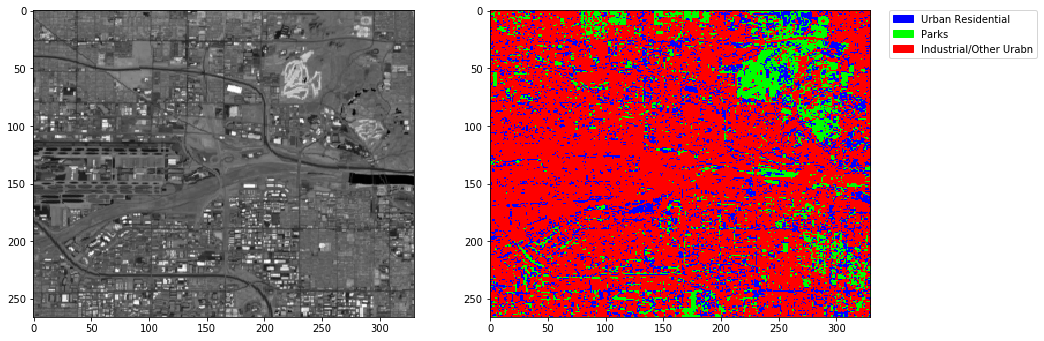

In [442]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # NA  
    (1, (0, 0, 255, 255)),  # Blue ## Urban 
    (2, (0, 255, 0, 255)),  #Green ##Park  
    (3, (255, 0, 0, 255)),  # Red ##Industrial
    (4, (0, 0, 0, 255)),  # NA # 160, 82, 45, 255
    (5, (0, 0, 0, 255))  # NA
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification')


# Now show the classmap next to the image
# Now show the classmap next to the image
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121)
ax.imshow(image_p[:, :, 4], cmap=plt.cm.Greys_r)

ax = f.add_subplot(122)
#plt.subplot(122)
ax.imshow(class_prediction, cmap=cmap, interpolation='none')

######
values = np.unique(class_prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
dic = {0:'Urban Residential', 1:'Parks', 2:'Industrial/Other Urabn'}
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=dic[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
######

plt.show()

In [302]:
rf.feature_importances_

array([0.12084671, 0.12550234, 0.11782817, 0.14430032, 0.22875409,
       0.13351906, 0.12924931])

### Use Spatial K-folds to divide the NYC into 5 grids and predict on each grid

In [422]:
data_test = gdal.Open('data/NYC_test.tif', gdal.GA_ReadOnly)

# Initialize a 3d array -- size based on raster dimensions
image_test = np.zeros((int(data_test.RasterYSize/2), int(data_test.RasterXSize/2), data_test.RasterCount))

# Allocate array using the first band's datatype
image_test_datatype = data_test.GetRasterBand(1).DataType

image_test = np.zeros((int(data_test.RasterYSize/2), int(data_test.RasterXSize/2), data_test.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_test_datatype))

# Loop over all bands in dataset

for b in range(data_test.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band_test = data_test.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image_test[:, :, b] = band_test.ReadAsArray()[:259,:311]

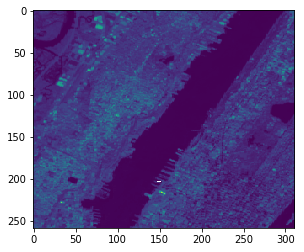

In [423]:
plt.imshow(image_test[:, :, 6])

### New Rasterization

In [427]:
# Import GDAL
from osgeo import gdal

# First we will open our raster image, to understand how we will want to rasterize our vector
raster_ds = gdal.Open('data/NYC_test.tif', gdal.GA_ReadOnly)

# Fetch number of rows and columns
ncol = int(raster_ds.RasterXSize/2)
nrow = int(raster_ds.RasterYSize/2)

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create('data/NYC_training_data.tif', ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [0],  # burn value 0
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=cat']  # put raster values according to the 'id' field values
                             )

# Close dataset
out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

Success


In [428]:
# Import NumPy for some statistics
import numpy as np

roi_ds = gdal.Open('data/NYC_training_data.tif', gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 51987 pixels
Class 1 contains 10036 pixels
Class 2 contains 6263 pixels
Class 3 contains 12263 pixels


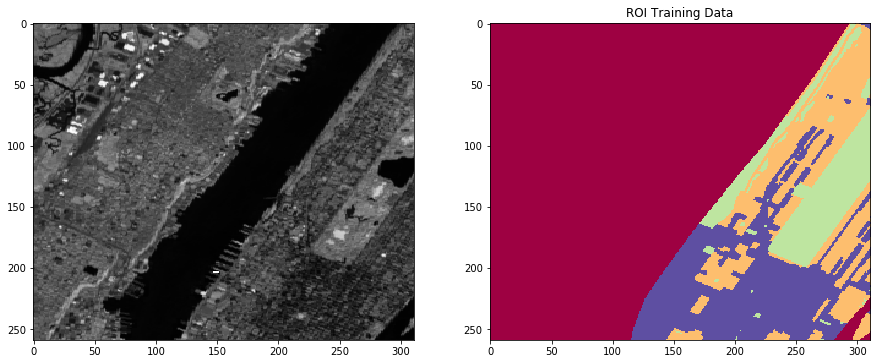

In [475]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('data/NYC_test.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('data/NYC_training_data.tif', gdal.GA_ReadOnly)

img = np.zeros((int(img_ds.RasterYSize/2), int(img_ds.RasterXSize/2),img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()[:259,:311]
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# Display them
#plt.subplot(121)
ax.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

#plt.subplot(122)
ax2.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

### Setting X and y again

In [476]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
clear = X[:, 7] <= 1

X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 28562 samples
The training data include 3 classes: [1 2 3]
Our X matrix is sized: (28562, 12)
Our y array is sized: (28562,)
After masking, our X matrix is sized: (28557, 7)
After masking, our y array is sized: (28557,)


### Rf again

In [454]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [496]:
rf.feature_importances_

array([0.14849662, 0.13882193, 0.11362181, 0.15355511, 0.20023162,
       0.13199427, 0.11327865])

In [497]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 81.67174423083658%


In [499]:
##Taking other half of the image

image_test_1 = np.zeros((int(data_test.RasterYSize/2), int(data_test.RasterXSize/2), data_test.RasterCount))

# Allocate array using the first band's datatype
image_test_datatype = data_test.GetRasterBand(1).DataType

image_test_1 = np.zeros((int(data_test.RasterYSize/2), int(data_test.RasterXSize/2), data_test.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_test_datatype))
for b in range(data_test.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band_test = data_test.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image_test_1[:, :, b] = band_test.ReadAsArray()[260:,312:]

In [501]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (image_test_1.shape[0] * image_test_1.shape[1], 7)

img_as_array = image_test_1[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=image_test_1.shape,
                                        n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)
# Now predict for each pixel
class_prediction_rf = rf.predict(img_as_array)

# Reshape our classification map
class_prediction_rf = class_prediction_rf.reshape(image_test_1[:, :, 0].shape)

Reshaped from (259, 311, 12) to (80549, 7)


## Running SVM

In [468]:
from sklearn import svm

clf = svm.SVC(kernel='rbf', C=1000) 
clf.fit(X, y)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [469]:
in_sample = 1.0*(clf.predict(X)==y).sum()/len(y)

print ('In sample accuracy: {:.2%}'.format(in_sample))

In sample accuracy: 68.09%


In [483]:
##Taking other half of the image

image_test_1 = np.zeros((int(data_test.RasterYSize/2), int(data_test.RasterXSize/2), data_test.RasterCount))

# Allocate array using the first band's datatype
image_test_datatype = data_test.GetRasterBand(1).DataType

image_test_1 = np.zeros((int(data_test.RasterYSize/2), int(data_test.RasterXSize/2), data_test.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_test_datatype))
for b in range(data_test.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band_test = data_test.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image_test_1[:, :, b] = band_test.ReadAsArray()[260:,312:]

In [506]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (image_test_1.shape[0] * image_test_1.shape[1], 7)

img_as_array = image_test_1[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=image_test_1.shape,
                                        n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)
# Now predict for each pixel
class_prediction_clf = clf.predict(img_as_array)

# Reshape our classification map
class_prediction_clf = class_prediction_clf.reshape(image_test_1[:, :, 0].shape)

Reshaped from (259, 311, 12) to (80549, 7)


/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


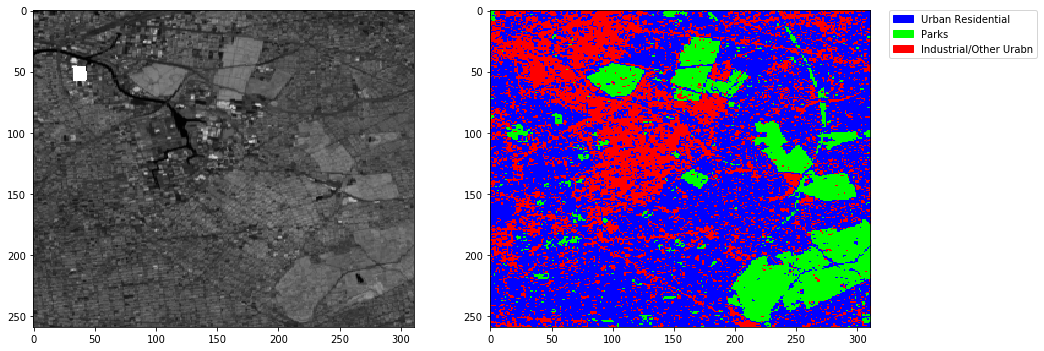

In [502]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # NA  
    (1, (0, 0, 255, 255)),  # Blue ## Urban 
    (2, (0, 255, 0, 255)),  #Green ##Park  
    (3, (255, 0, 0, 255)),  # Red ##Industrial
    (4, (0, 0, 0, 255)),  # NA # 160, 82, 45, 255
    (5, (0, 0, 0, 255))  # NA
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification')


# Now show the classmap next to the image
# Now show the classmap next to the image
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121)
ax.imshow(image_test_1[:, :, 4], cmap=plt.cm.Greys_r)

ax = f.add_subplot(122)
#plt.subplot(122)
ax.imshow(class_prediction_rf, cmap=cmap, interpolation='none')

######
values = np.unique(class_prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
dic = {0:'Urban Residential', 1:'Parks', 2:'Industrial/Other Urabn'}
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=dic[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
######

plt.show()

## Logistic Regression

In [503]:
from sklearn.linear_model import LogisticRegression

lrmodel = LogisticRegression(penalty= 'l2', C= 0.5)

lrmodel.fit(X,y)




LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [504]:
in_sample = 1.0*(lrmodel.predict(X)==y).sum()/len(y)

print ('In sample accuracy: {:.2%}'.format(in_sample))

In sample accuracy: 61.74%


In [505]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (image_test_1.shape[0] * image_test_1.shape[1], 7)

img_as_array = image_test_1[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=image_test_1.shape,
                                        n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)
# Now predict for each pixel
class_prediction_lr = lrmodel.predict(img_as_array)

# Reshape our classification map
class_prediction_lr = class_prediction_lr.reshape(image_test_1[:, :, 0].shape)

Reshaped from (259, 311, 12) to (80549, 7)


/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


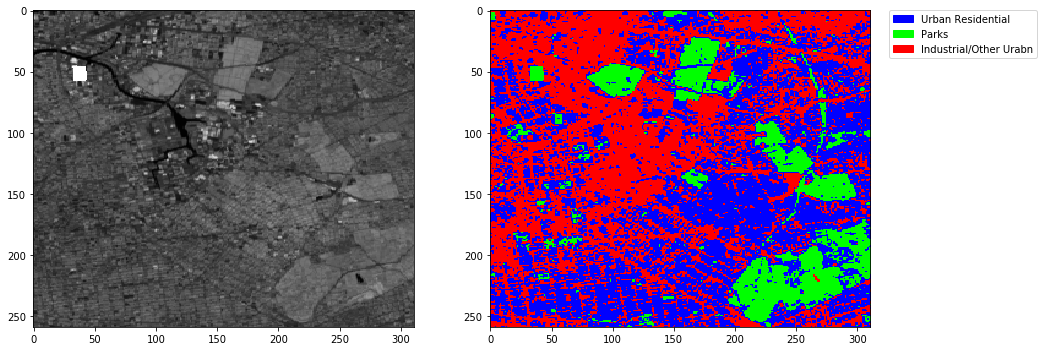

In [485]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # NA  
    (1, (0, 0, 255, 255)),  # Blue ## Urban 
    (2, (0, 255, 0, 255)),  #Green ##Park  
    (3, (255, 0, 0, 255)),  # Red ##Industrial
    (4, (0, 0, 0, 255)),  # NA # 160, 82, 45, 255
    (5, (0, 0, 0, 255))  # NA
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification')


# Now show the classmap next to the image
# Now show the classmap next to the image
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121)
ax.imshow(image_test_1[:, :, 4], cmap=plt.cm.Greys_r)

ax = f.add_subplot(122)
#plt.subplot(122)
ax.imshow(class_prediction, cmap=cmap, interpolation='none')

######
values = np.unique(class_prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
dic = {0:'Urban Residential', 1:'Parks', 2:'Industrial/Other Urabn'}
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=dic[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
######

plt.show()

## Plot all together 

/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


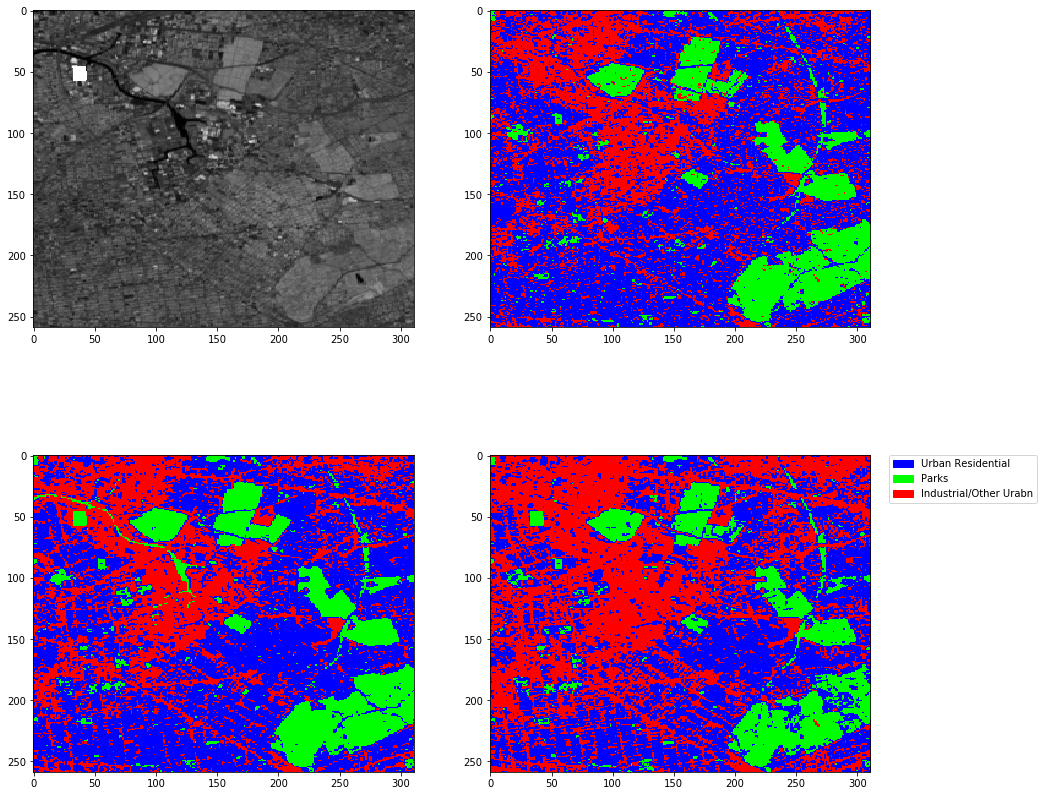

In [507]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # NA  
    (1, (0, 0, 255, 255)),  # Blue ## Urban 
    (2, (0, 255, 0, 255)),  #Green ##Park  
    (3, (255, 0, 0, 255)),  # Red ##Industrial
    (4, (0, 0, 0, 255)),  # NA # 160, 82, 45, 255
    (5, (0, 0, 0, 255))  # NA
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification')


# Now show the classmap next to the image
# Now show the classmap next to the image
f = plt.figure(figsize=(15,15))
f.subplots
ax = f.add_subplot(2,2,1)
ax.imshow(image_test_1[:, :, 4], cmap=plt.cm.Greys_r)

ax = f.add_subplot(2,2,2)
#plt.subplot(122)
ax.imshow(class_prediction_rf, cmap=cmap, interpolation='none')

ax = f.add_subplot(2,2,3)
#plt.subplot(122)
ax.imshow(class_prediction_clf, cmap=cmap, interpolation='none')

ax = f.add_subplot(2,2,4)
#plt.subplot(122)
ax.imshow(class_prediction_lr, cmap=cmap, interpolation='none')

######
values = np.unique(class_prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
dic = {0:'Urban Residential', 1:'Parks', 2:'Industrial/Other Urabn'}
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=dic[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
######

plt.show()

In [492]:
f.subplots?